In [5]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Load dataset
df = pd.read_csv("data/cardekho_dataset.csv")
df.drop(columns=["Unnamed: 0", "car_name"], inplace=True)

# Define categorical & numerical features
categorical_features = ['brand', 'model', 'seller_type', 'fuel_type', 'transmission_type', 'seats']
numerical_features = ["vehicle_age", "km_driven", "mileage", "max_power"]

# Apply transformations: One-Hot Encoding + Scaling
one_hot = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
scaler = StandardScaler()

transformer = ColumnTransformer([
    ("one_hot", one_hot, categorical_features),
    ("scaler", scaler, numerical_features)
])

# Transform data
X = transformer.fit_transform(df)

# Determine optimal clusters (Elbow Method)
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

# Fit K-Means with optimal clusters (assuming 4 clusters based on the elbow method)
optimal_clusters = 4  # Adjust based on Elbow Curve
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
df["Cluster"] = kmeans.fit_predict(X)

# Function to recommend similar cars
def recommend_car(user_input, df, transformer, kmeans):
    # Convert user input to DataFrame
    user_df = pd.DataFrame([user_input])

    # Transform user input
    user_transformed = transformer.transform(user_df)

    # Predict user's cluster
    user_cluster = kmeans.predict(user_transformed)[0]

    # Get recommended cars from the same cluster
    recommendations = df[df["Cluster"] == user_cluster].sample(5)  # Select 5 random similar cars
    return recommendations[["brand", "model", "fuel_type", "transmission_type", "max_power", "mileage", "km_driven"]]

# Example user input
user_input = {
    "brand": "Maruti",
    "model": "Swift",
    "vehicle_age": 5,
    "fuel_type": "Petrol",
    "transmission_type": "Manual",
    "mileage": 15,
    "max_power": 82,
    "seats": 5,
    "km_driven": 50000,
    "seller_type": "Individual"
}

# Get recommendations
recommendations = recommend_car(user_input, df, transformer, kmeans)
print(recommendations)


        brand        model fuel_type transmission_type  max_power  mileage  \
3834   Maruti         Ciaz    Petrol            Manual      91.10    20.73   
12173  Maruti  Swift Dzire    Petrol            Manual      85.80    19.00   
12387    Ford         Figo    Petrol            Manual      86.80    18.16   
11176   Honda        Amaze    Petrol         Automatic      88.76    18.30   
6804   Maruti         Alto    Petrol            Manual      47.30    24.70   

       km_driven  
3834       71000  
12173      50125  
12387      68000  
11176      17000  
6804       33977  


In [3]:
df.info

<bound method DataFrame.info of           brand     model  vehicle_age  km_driven seller_type fuel_type  \
0        Maruti      Alto            9     120000  Individual    Petrol   
1       Hyundai     Grand            5      20000  Individual    Petrol   
2       Hyundai       i20           11      60000  Individual    Petrol   
3        Maruti      Alto            9      37000  Individual    Petrol   
4          Ford  Ecosport            6      30000      Dealer    Diesel   
...         ...       ...          ...        ...         ...       ...   
15406   Hyundai       i10            9      10723      Dealer    Petrol   
15407    Maruti    Ertiga            2      18000      Dealer    Petrol   
15408     Skoda     Rapid            6      67000      Dealer    Diesel   
15409  Mahindra    XUV500            5    3800000      Dealer    Diesel   
15410     Honda      City            2      13000      Dealer    Petrol   

      transmission_type  mileage  engine  max_power  seats  selling

In [7]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

silhouette = silhouette_score(X, df["Cluster"])
db_index = davies_bouldin_score(X, df["Cluster"])

print(f"Silhouette Score: {silhouette:.3f}")
print(f"Davies-Bouldin Index: {db_index:.3f}")


Silhouette Score: 0.149
Davies-Bouldin Index: 1.905


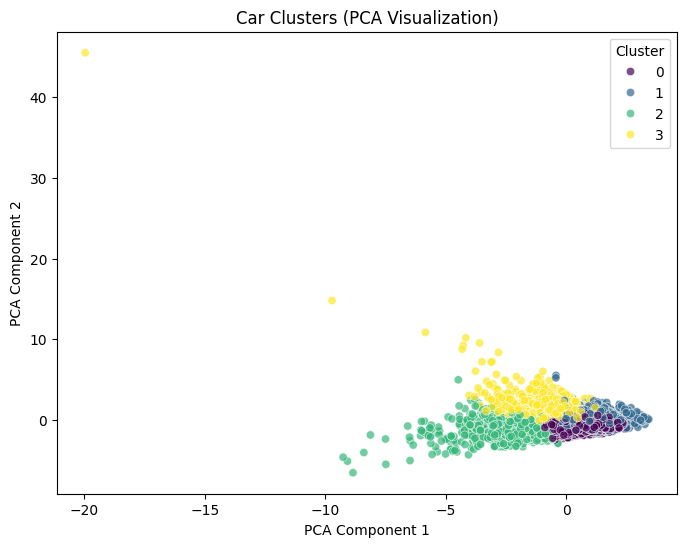

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Reduce to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df["Cluster"], palette="viridis", alpha=0.7)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Car Clusters (PCA Visualization)")
plt.legend(title="Cluster")
plt.show()


In [11]:
import joblib
# Save the trained KMeans model
joblib.dump(kmeans, "models/kmeans_model.pkl")

# Save the transformer (OneHotEncoder + Scaler)
joblib.dump(transformer, "models/transformer.pkl")

print("Models and transformer saved successfully!")


Models and transformer saved successfully!
